Data Integration & Preprocessing

In [1]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
# Load data tables
student_info = pd.read_csv("studentInfo.csv")
student_vle = pd.read_csv("studentVle.csv")
assessments = pd.read_csv("studentAssessment.csv")
courses = pd.read_csv("courses.csv")

In [3]:
# Aggregate VLE interactions per student
vle_agg = student_vle.groupby('id_student')['sum_click'].sum().reset_index()
vle_agg.rename(columns={'sum_click': 'total_clicks'}, inplace=True)

In [4]:
# Aggregate assessment performance per student
assessments_agg = assessments.groupby('id_student').agg({
    'score': 'mean',
    'id_assessment': 'count'
}).reset_index()
assessments_agg.rename(columns={
    'score': 'avg_score',
    'id_assessment': 'total_assessments'
}, inplace=True)

In [5]:
# Merge datasets
df = student_info.merge(vle_agg, on='id_student', how='left')
df = df.merge(assessments_agg, on='id_student', how='left')
df = df.merge(courses, on=['code_module', 'code_presentation'], how='left')

In [6]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,total_clicks,avg_score,total_assessments,module_presentation_length
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0,82.0,5.0,268
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0,66.4,5.0,268
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0,NaN,NaN,268
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0,76.0,5.0,268
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0,54.4,5.0,268


In [7]:
df.isnull().sum()

code_module                      0
code_presentation                0
id_student                       0
gender                           0
region                           0
highest_education                0
imd_band                      1111
age_band                         0
num_of_prev_attempts             0
studied_credits                  0
disability                       0
final_result                     0
total_clicks                  2852
avg_score                     5866
total_assessments             5847
module_presentation_length       0
dtype: int64

In [8]:
# Handle missing values
df.fillna(0, inplace=True)

In [9]:
df.isnull().sum()

code_module                   0
code_presentation             0
id_student                    0
gender                        0
region                        0
highest_education             0
imd_band                      0
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
final_result                  0
total_clicks                  0
avg_score                     0
total_assessments             0
module_presentation_length    0
dtype: int64

In [10]:
# Define target column (1 = Withdrawn, 0 = others)
df['target'] = df['final_result'].apply(lambda x: 1 if x == 'Withdrawn' else 0)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32593 non-null  object 
 1   code_presentation           32593 non-null  object 
 2   id_student                  32593 non-null  int64  
 3   gender                      32593 non-null  object 
 4   region                      32593 non-null  object 
 5   highest_education           32593 non-null  object 
 6   imd_band                    32593 non-null  object 
 7   age_band                    32593 non-null  object 
 8   num_of_prev_attempts        32593 non-null  int64  
 9   studied_credits             32593 non-null  int64  
 10  disability                  32593 non-null  object 
 11  final_result                32593 non-null  object 
 12  total_clicks                32593 non-null  float64
 13  avg_score                   325

In [12]:
for col in df.columns:
    types = df[col].apply(type).nunique()
    if types > 1:
        print(f"⚠️ Column '{col}' has mixed types.")

⚠️ Column 'imd_band' has mixed types.


In [13]:
# Convert imd-band to string
df['imd_band'] = df['imd_band'].astype(str).fillna('Unknown')

In [14]:
df['region'].value_counts()

region
Scotland                3446
East Anglian Region     3340
London Region           3216
South Region            3092
North Western Region    2906
West Midlands Region    2582
South West Region       2436
East Midlands Region    2365
South East Region       2111
Wales                   2086
Yorkshire Region        2006
North Region            1823
Ireland                 1184
Name: count, dtype: int64

In [15]:
# One-Hot Encode 'region'
region_dummies = pd.get_dummies(df['region'], prefix='region', drop_first=True)
df = pd.concat([df, region_dummies], axis=1)

# Label Encode other categorical columns
label_cols = ['gender', 'highest_education', 'imd_band', 'age_band', 'disability']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [16]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region
0,AAA,2013J,11391,1,East Anglian Region,1,9,2,0,240,...,False,False,False,False,False,False,False,False,False,False
1,AAA,2013J,28400,0,Scotland,1,2,1,0,60,...,False,False,False,True,False,False,False,False,False,False
2,AAA,2013J,30268,0,North Western Region,0,3,1,0,60,...,False,False,True,False,False,False,False,False,False,False
3,AAA,2013J,31604,0,South East Region,0,5,1,0,60,...,False,False,False,False,True,False,False,False,False,False
4,AAA,2013J,32885,0,West Midlands Region,2,5,0,0,60,...,False,False,False,False,False,False,False,False,True,False


In [17]:
# Normalize numerical columns
scaler = StandardScaler()
num_cols = ['num_of_prev_attempts', 'studied_credits', 'total_clicks', 'avg_score', 'total_assessments']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [18]:
# Keeping only one row per student
df = df.drop_duplicates(subset='id_student')

EDA

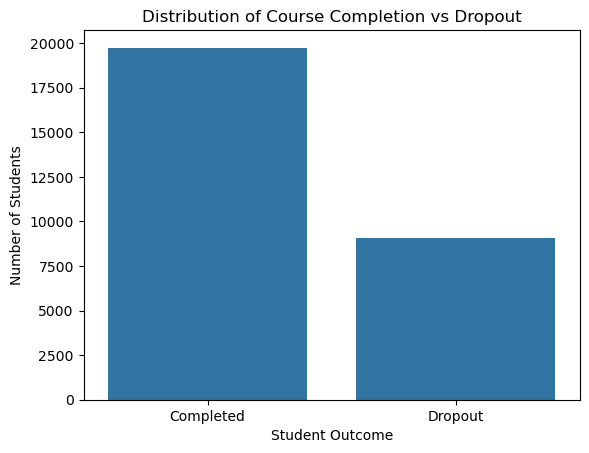

In [75]:
# Class Distribution (Dropout vs. Completed)
sns.countplot(data=df, x='target')
plt.title('Distribution of Course Completion vs Dropout')
plt.xticks([0, 1], ['Completed', 'Dropout'])
plt.xlabel('Student Outcome')
plt.ylabel('Number of Students')
plt.show()

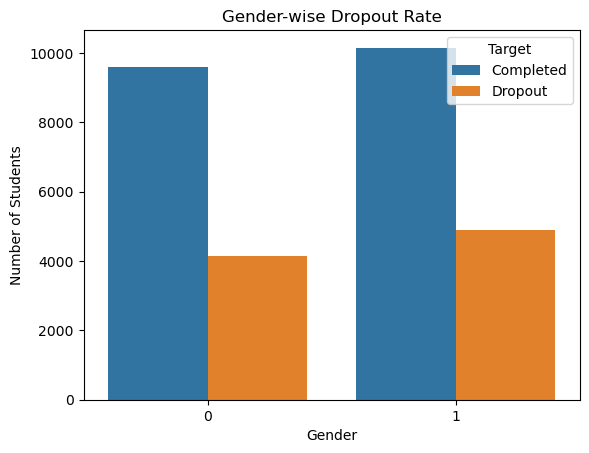

In [76]:
#Gender vs. Dropout Rate
sns.countplot(data=df, x='gender', hue='target')
plt.title('Gender-wise Dropout Rate')
plt.xlabel('Gender')
plt.ylabel('Number of Students')
plt.legend(title='Target', labels=['Completed', 'Dropout'])
plt.show()

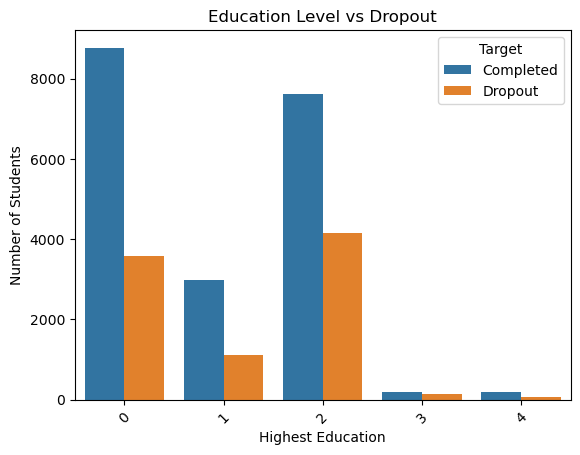

In [77]:
#Education Level vs Dropout
sns.countplot(data=df, x='highest_education', hue='target')
plt.title('Education Level vs Dropout')
plt.xticks(rotation=45)
plt.xlabel('Highest Education')
plt.ylabel('Number of Students')
plt.legend(title='Target', labels=['Completed', 'Dropout'])
plt.show()

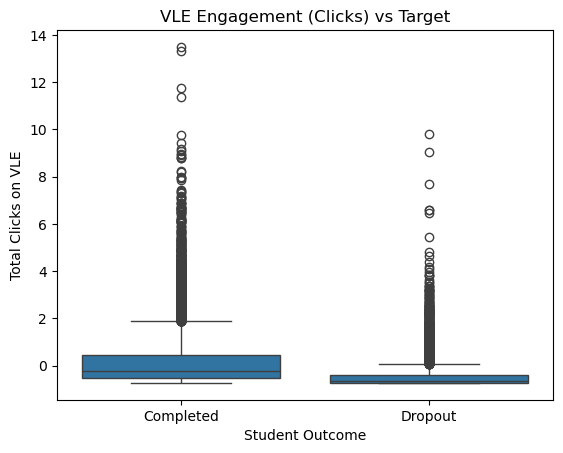

In [78]:
# Total Clicks vs Dropout
sns.boxplot(data=df, x='target', y='total_clicks')
plt.title('VLE Engagement (Clicks) vs Target')
plt.xticks([0, 1], ['Completed', 'Dropout'])
plt.xlabel('Student Outcome')
plt.ylabel('Total Clicks on VLE')
plt.show()

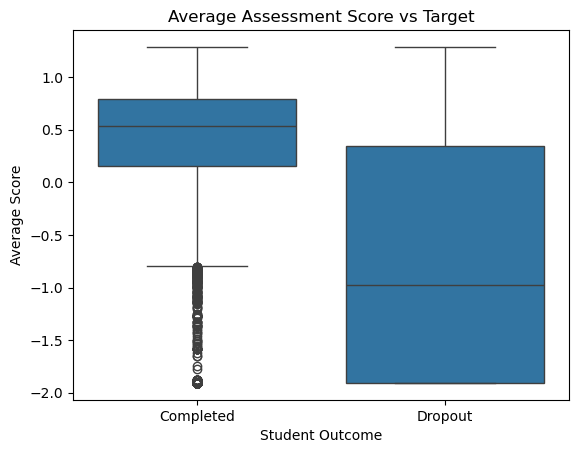

In [79]:
#  Avg Score vs Dropout
sns.boxplot(data=df, x='target', y='avg_score')
plt.title('Average Assessment Score vs Target')
plt.xticks([0, 1], ['Completed', 'Dropout'])
plt.xlabel('Student Outcome')
plt.ylabel('Average Score')
plt.show()

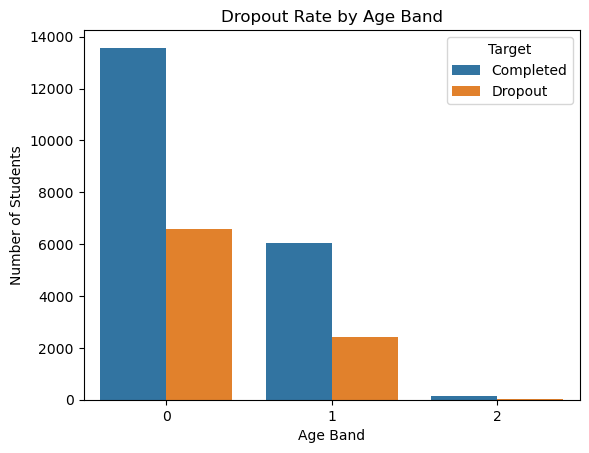

In [80]:
# Age Band vs Dropout
sns.countplot(data=df, x='age_band', hue='target')
plt.title('Dropout Rate by Age Band')
plt.xlabel('Age Band')
plt.ylabel('Number of Students')
plt.legend(title='Target', labels=['Completed', 'Dropout'])
plt.show()

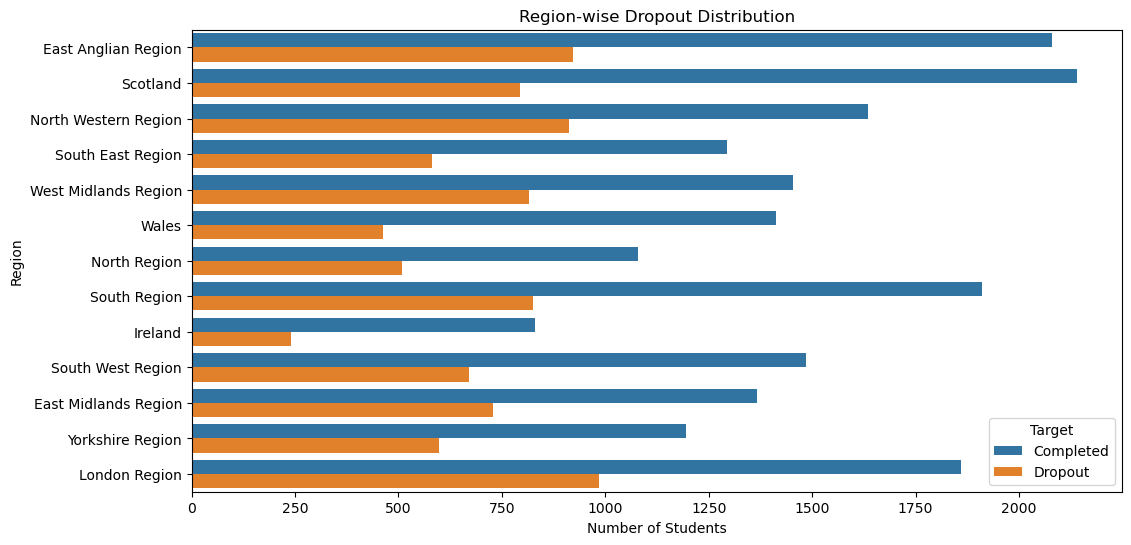

In [81]:
# Region-wise Dropouts
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='region', hue='target')
plt.title('Region-wise Dropout Distribution')
plt.xlabel('Number of Students')
plt.ylabel('Region')
plt.legend(title='Target', labels=['Completed', 'Dropout'])
plt.show()

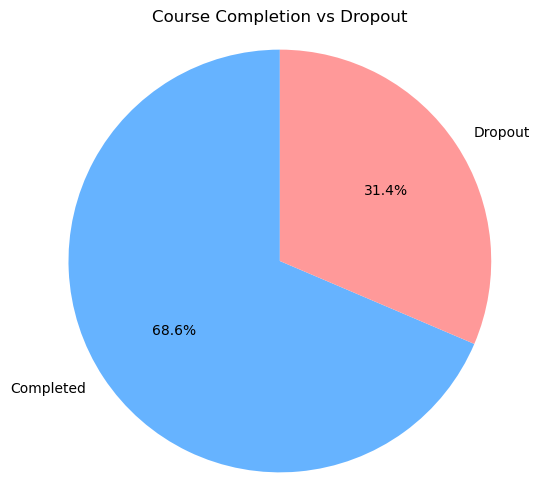

In [82]:
# Dropout vs Completed
labels = ['Completed', 'Dropout']
sizes = df['target'].value_counts().sort_index()
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Course Completion vs Dropout')
plt.axis('equal')
plt.show()

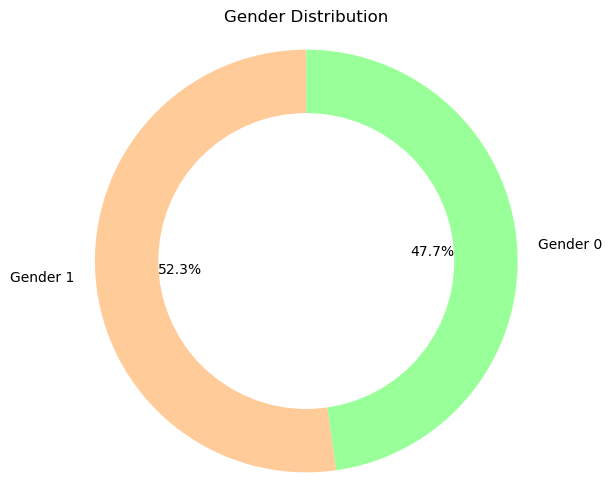

In [83]:
#  Gender Distribution
gender_counts = df['gender'].value_counts()
labels = [f'Gender {i}' for i in gender_counts.index]
plt.figure(figsize=(6,6))
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), colors=['#ffcc99','#99ff99'])
plt.title('Gender Distribution')
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))  # Donut hole
plt.axis('equal')
plt.show()

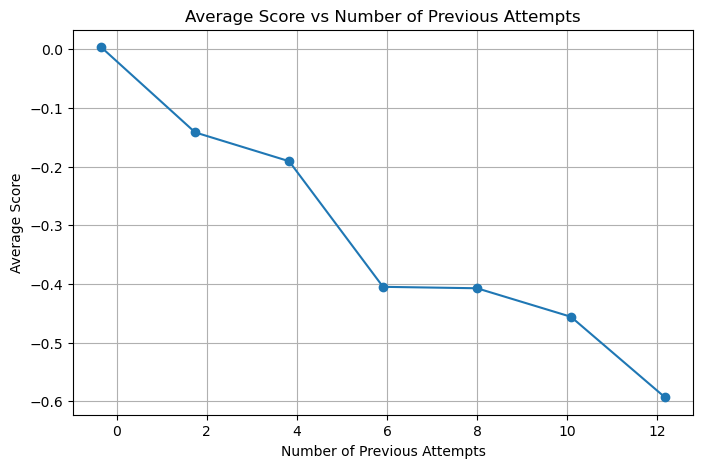

In [84]:
# Average Score vs Number of Previous Attempts
avg_score_by_attempts = df.groupby('num_of_prev_attempts')['avg_score'].mean().reset_index()
plt.figure(figsize=(8,5))
plt.plot(avg_score_by_attempts['num_of_prev_attempts'], avg_score_by_attempts['avg_score'], marker='o')
plt.title('Average Score vs Number of Previous Attempts')
plt.xlabel('Number of Previous Attempts')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()

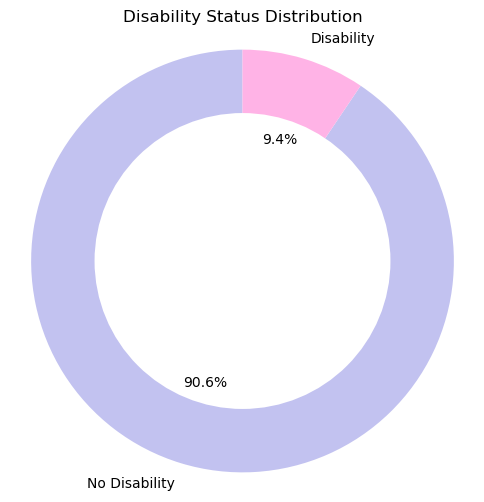

In [85]:
#  Disability Status
disability_counts = df['disability'].value_counts()
labels = ['No Disability', 'Disability']
plt.figure(figsize=(6,6))
plt.pie(disability_counts, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), colors=['#c2c2f0','#ffb3e6'])
plt.title('Disability Status Distribution')
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))
plt.axis('equal')
plt.show()

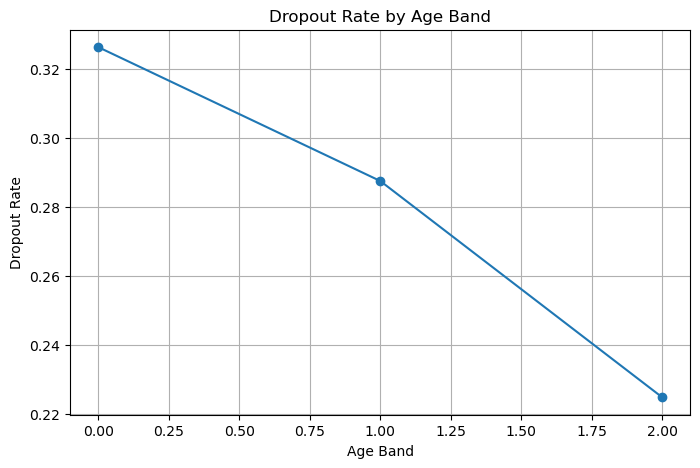

In [86]:
#  Dropout Rate by Age Band
age_dropout = df.groupby('age_band')['target'].mean().reset_index()
plt.figure(figsize=(8,5))
plt.plot(age_dropout['age_band'], age_dropout['target'], marker='o')
plt.title('Dropout Rate by Age Band')
plt.xlabel('Age Band')
plt.ylabel('Dropout Rate')
plt.grid(True)
plt.show()

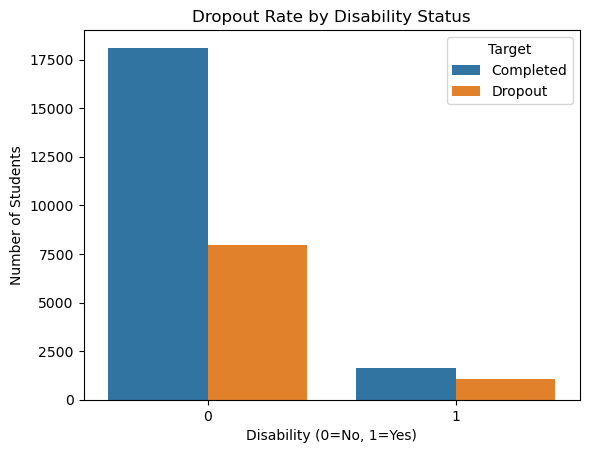

In [87]:
# Disability vs Dropout Rate
sns.countplot(data=df, x='disability', hue='target')
plt.title('Dropout Rate by Disability Status')
plt.xlabel('Disability (0=No, 1=Yes)')
plt.ylabel('Number of Students')
plt.legend(title='Target', labels=['Completed', 'Dropout'])
plt.show()

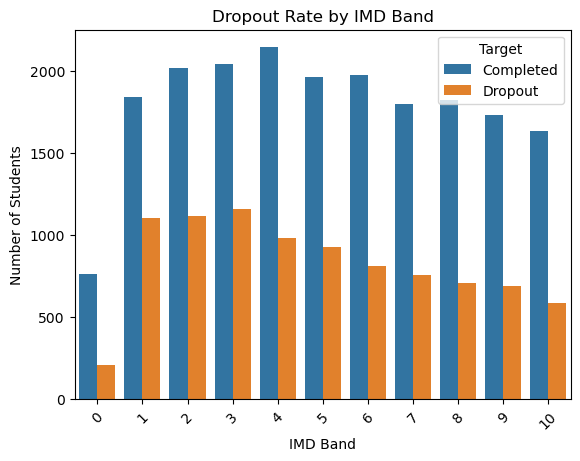

In [88]:
# IMD Band vs Dropout
sns.countplot(data=df, x='imd_band', hue='target')
plt.title('Dropout Rate by IMD Band')
plt.xlabel('IMD Band')
plt.ylabel('Number of Students')
plt.legend(title='Target', labels=['Completed', 'Dropout'])
plt.xticks(rotation=45)
plt.show()

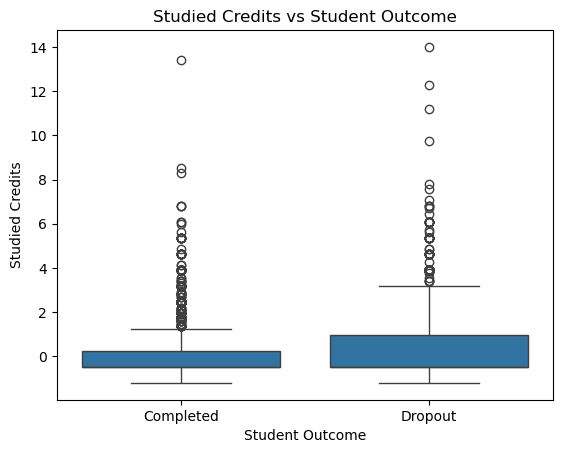

In [89]:
# Studied Credits vs Dropout
sns.boxplot(data=df, x='target', y='studied_credits')
plt.title('Studied Credits vs Student Outcome')
plt.xticks([0, 1], ['Completed', 'Dropout'])
plt.xlabel('Student Outcome')
plt.ylabel('Studied Credits')
plt.show()

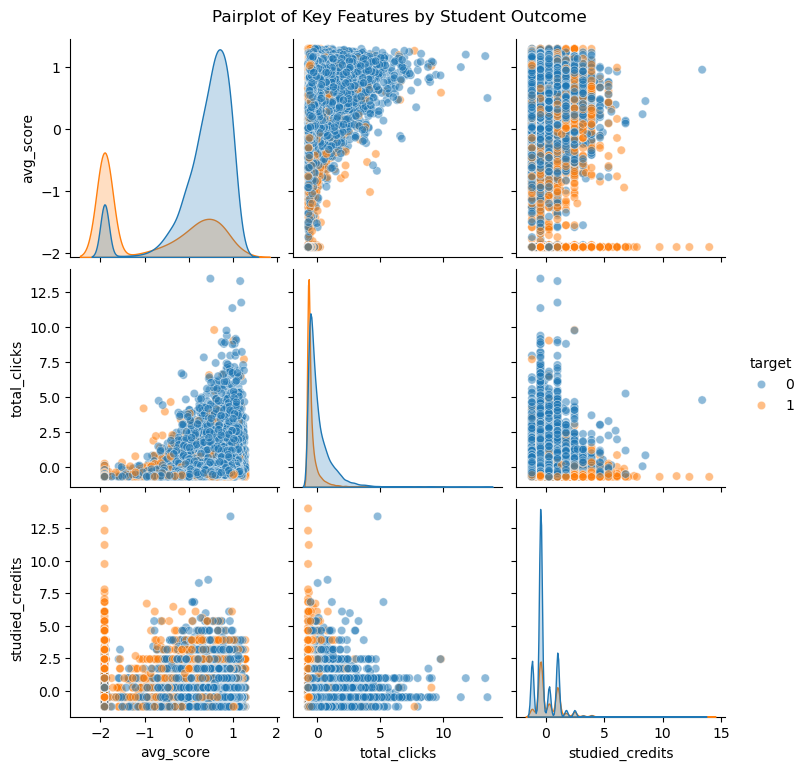

In [90]:
# Pairplot for selected features
sns.pairplot(df, vars=['avg_score', 'total_clicks', 'studied_credits'], hue='target', plot_kws={'alpha':0.5})
plt.suptitle('Pairplot of Key Features by Student Outcome', y=1.02)
plt.show()

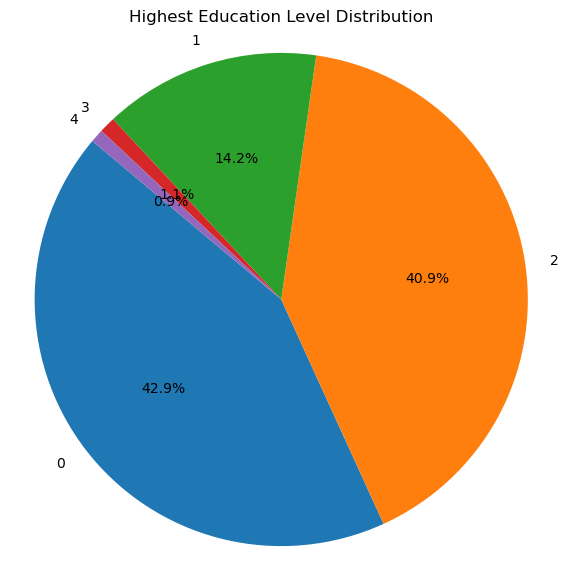

In [91]:
#  Highest Education Level
edu_counts = df['highest_education'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(edu_counts, labels=edu_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Highest Education Level Distribution')
plt.axis('equal')
plt.show()

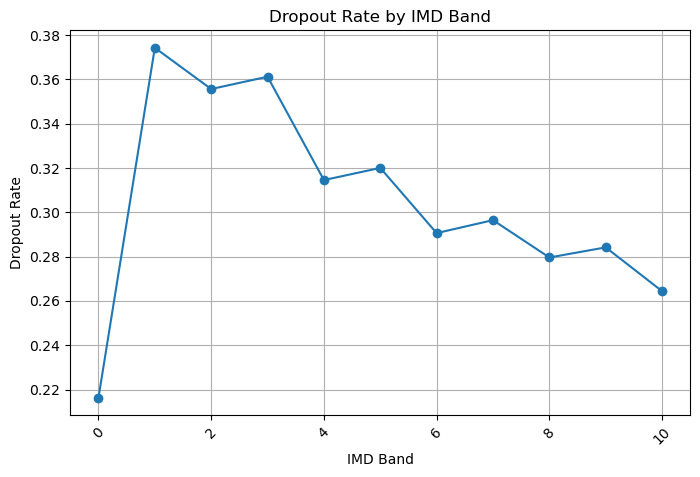

In [92]:
#  Dropout Rate by IMD Band
imd_dropout = df.groupby('imd_band')['target'].mean().reset_index()
plt.figure(figsize=(8,5))
plt.plot(imd_dropout['imd_band'], imd_dropout['target'], marker='o')
plt.title('Dropout Rate by IMD Band')
plt.xlabel('IMD Band')
plt.ylabel('Dropout Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

C:\Users\gulsh\AppData\Local\Temp\ipykernel_22868\304543567.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_dropout.values, y=region_dropout.index, palette='viridis')


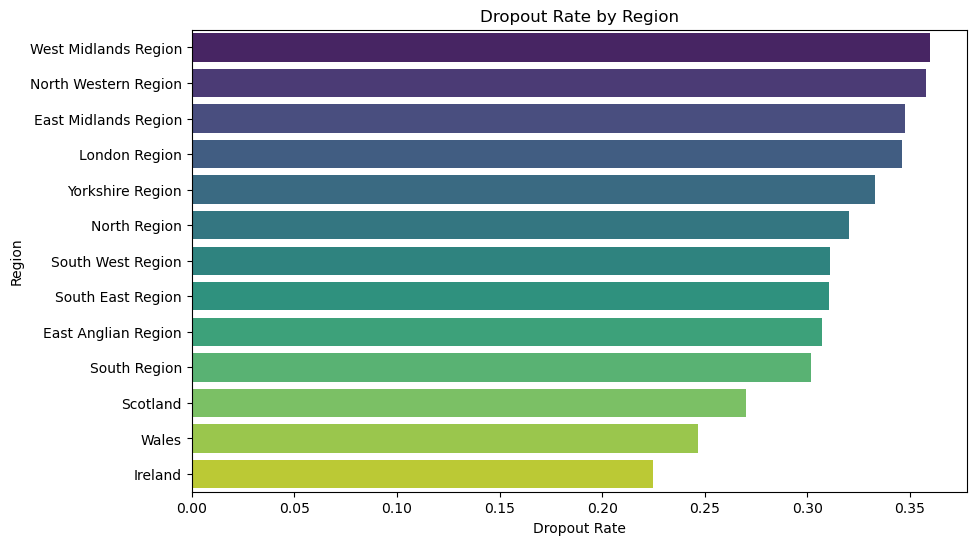

In [93]:
#  Dropout Rate by Region
region_dropout = df.groupby('region')['target'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=region_dropout.values, y=region_dropout.index, palette='viridis')
plt.title('Dropout Rate by Region')
plt.xlabel('Dropout Rate')
plt.ylabel('Region')
plt.show()

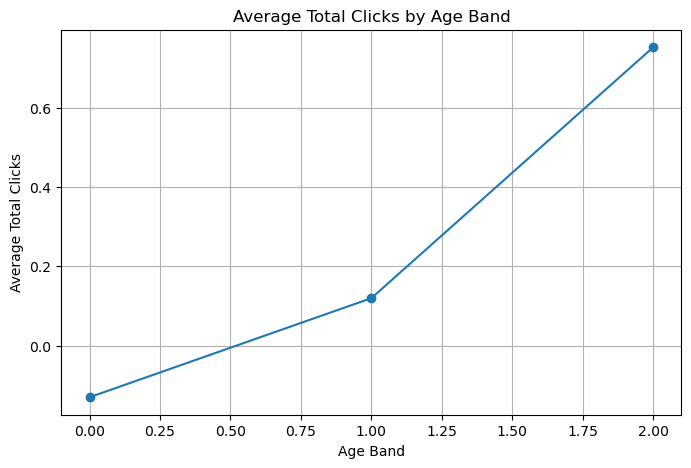

In [94]:
#  Average Total Clicks by Age Band
clicks_by_age = df.groupby('age_band')['total_clicks'].mean().reset_index()
plt.figure(figsize=(8,5))
plt.plot(clicks_by_age['age_band'], clicks_by_age['total_clicks'], marker='o')
plt.title('Average Total Clicks by Age Band')
plt.xlabel('Age Band')
plt.ylabel('Average Total Clicks')
plt.grid(True)
plt.show()

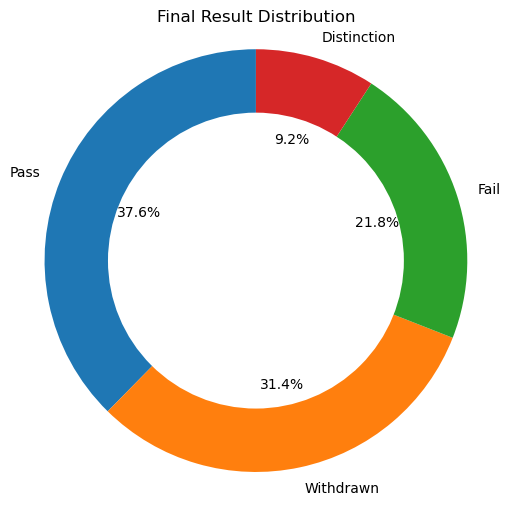

In [95]:
# Final Result Distribution
final_counts = df['final_result'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(final_counts, labels=final_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
plt.title('Final Result Distribution')
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))
plt.axis('equal')
plt.show()

In [19]:
# Recreate X and y from the fully combined dataset
X = df.drop(['target', 'code_module', 'code_presentation', 'region', 'final_result'], axis=1)
y = df['target']

In [20]:
# Make sure all boolean columns are converted
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

In [21]:
# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Apply SMOTE ONLY on subset (gender==1 and disability==1) of training data
mask = (X_train['gender'] == 1) & (X_train['disability'] == 1)
X_smote = X_train[mask]
y_smote = y_train[mask]

# Drop non-numeric columns if any remain (precautionary)
drop_cols = ['code_module', 'code_presentation', 'region']
X_smote = X_smote.drop(columns=drop_cols, errors='ignore')

# Convert boolean columns to int
bool_cols = X_smote.select_dtypes(include='bool').columns
X_smote[bool_cols] = X_smote[bool_cols].astype(int)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)

# Recombine SMOTE data with the rest of the training set
X_train_rest = X_train[~mask]
y_train_rest = y_train[~mask]

X_train_final = pd.concat([X_train_rest, pd.DataFrame(X_resampled, columns=X_smote.columns)], axis=0)
y_train_final = pd.concat([y_train_rest, pd.Series(y_resampled)], axis=0)

In [23]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_final, y_train_final)
y_pred_logreg = logreg.predict(X_test)

In [24]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_final, y_train_final)
y_pred_rf = rf.predict(X_test)

In [25]:
# Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

In [26]:
# Evaluation Report
evaluate_model("Logistic Regression", y_test, y_pred_logreg)
evaluate_model("Random Forest", y_test, y_pred_rf)


Model: Logistic Regression
Accuracy: 0.8143130102483933
Precision: 0.758
Recall: 0.6169289202387411
F1 Score: 0.6802273407119354

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      3914
           1       0.76      0.62      0.68      1843

    accuracy                           0.81      5757
   macro avg       0.80      0.76      0.77      5757
weighted avg       0.81      0.81      0.81      5757


Model: Random Forest
Accuracy: 0.8193503560882404
Precision: 0.7552447552447552
Recall: 0.6446011937059143
F1 Score: 0.6955503512880562

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      3914
           1       0.76      0.64      0.70      1843

    accuracy                           0.82      5757
   macro avg       0.80      0.77      0.78      5757
weighted avg       0.82      0.82      0.82      5757



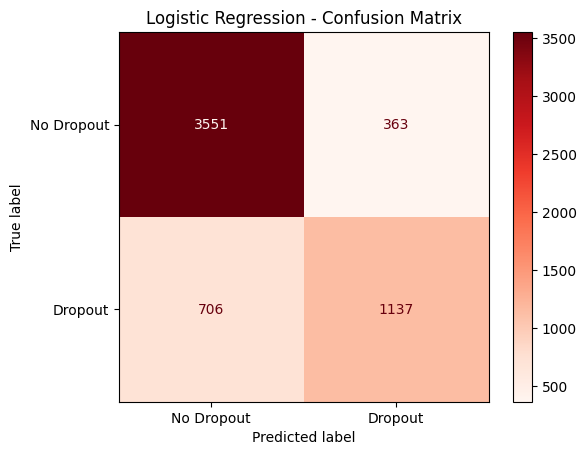

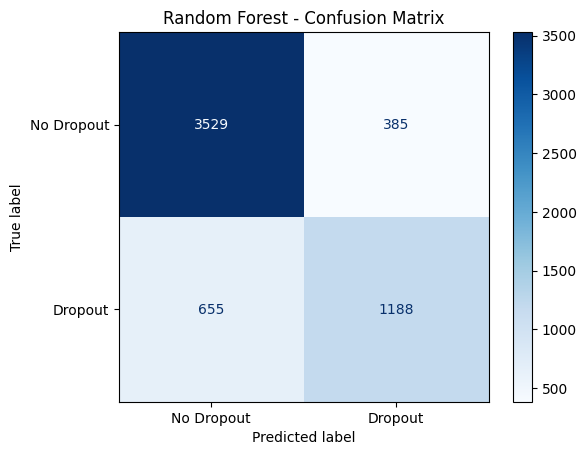

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Logistic Regression Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=["No Dropout", "Dropout"])
disp_logreg.plot(cmap="Reds")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No Dropout", "Dropout"])
disp_rf.plot(cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.show()

In [28]:
#Cross-validation scores
logreg_cv = cross_val_score(logreg, X_train, y_train, cv=5)
rf_cv = cross_val_score(rf, X_train, y_train, cv=5)

print("\nLogistic Regression CV Accuracy Scores:", logreg_cv)
print("Mean CV Accuracy (LogReg):", logreg_cv.mean())
print("\nRandom Forest CV Accuracy Scores:", rf_cv)
print("Mean CV Accuracy (RF):", rf_cv.mean())


Logistic Regression CV Accuracy Scores: [0.80807642 0.8074251  0.81133304 0.80390879 0.80130293]
Mean CV Accuracy (LogReg): 0.8064092579994089

Random Forest CV Accuracy Scores: [0.82066869 0.82153713 0.82566218 0.82301846 0.81715527]
Mean CV Accuracy (RF): 0.8216083444951894
